# Import libraries

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import iqr
from scipy.stats import zscore

from utils import eda_train_path

# Load datasets

In [5]:
train_df = pd.read_csv(eda_train_path)

# Funcs

## Detect outliers (stat)

In [6]:
def detect_outliers_iqr(df, column):
    """
    Выявляет выбросы с помощью IQR (межквартильного размаха).
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr_value = iqr(df[column])  # Готовая функция
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    return (df[column] < lower_bound) | (df[column] > upper_bound)

In [10]:
def detect_outliers_zscore(df, column, threshold=3):
    """
    Выявляет выбросы с помощью Z-score.
    """
    return abs(zscore(df[column])) > threshold  # Готовая функция

In [11]:
def detect_outliers_percentile(df, column, percentile=95):
    """
    Выявляет выбросы на основе percentiles (например, 95%).
    """
    threshold = np.percentile(df[column], percentile)
    return df[column] > threshold

## Plots

In [15]:
def plot_outliers(df, column, methods):
    """
    Строит boxplot, histogram и distribution plot для анализа выбросов.
    
    df: DataFrame
    column: название столбца с выбросами
    methods: словарь с методами обнаружения выбросов
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))

    title = column.replace("_", " ").capitalize()

    # Boxplot
    sns.boxplot(x=df[column], ax=axes[0])
    axes[0].set_title(f"Boxplot of {title}")

    # Histogram
    sns.histplot(df[column], bins=50, kde=True, ax=axes[1])
    axes[1].set_title(f"Histogram of {title}")

    # Distribution plot (график плотности + выбросы по методам)
    for method, outliers in methods.items():
        sns.kdeplot(df.loc[~outliers, column], label=f"Non-outliers ({method})", ax=axes[2])
        sns.kdeplot(df.loc[outliers, column], label=f"Outliers ({method})", ax=axes[2], linestyle="dashed")
    
    axes[2].set_title(f"Distribution of {title} with Outliers")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Rate

In [18]:
def detect_outliers(df, column):
    """
    Вычисляет выбросы по разным методам и возвращает их статистику.
    """
    methods = {
        "IQR": detect_outliers_iqr(df, column),
        "Z-score": detect_outliers_zscore(df, column),
        "95th Percentile": detect_outliers_percentile(df, column)
    }
    
    results = {method: outliers.sum() for method, outliers in methods.items()}
    
    # Вывод результатов
    for method, count in results.items():
        percentage = (count / len(df)) * 100
        print(f"{method}: {count} выбросов ({percentage:.2f}%)")

    return methods  # Возвращаем словарь для дальнейшего анализа

IQR: 14649 выбросов (5.12%)
Z-score: 4726 выбросов (1.65%)
95th Percentile: 14314 выбросов (5.00%)


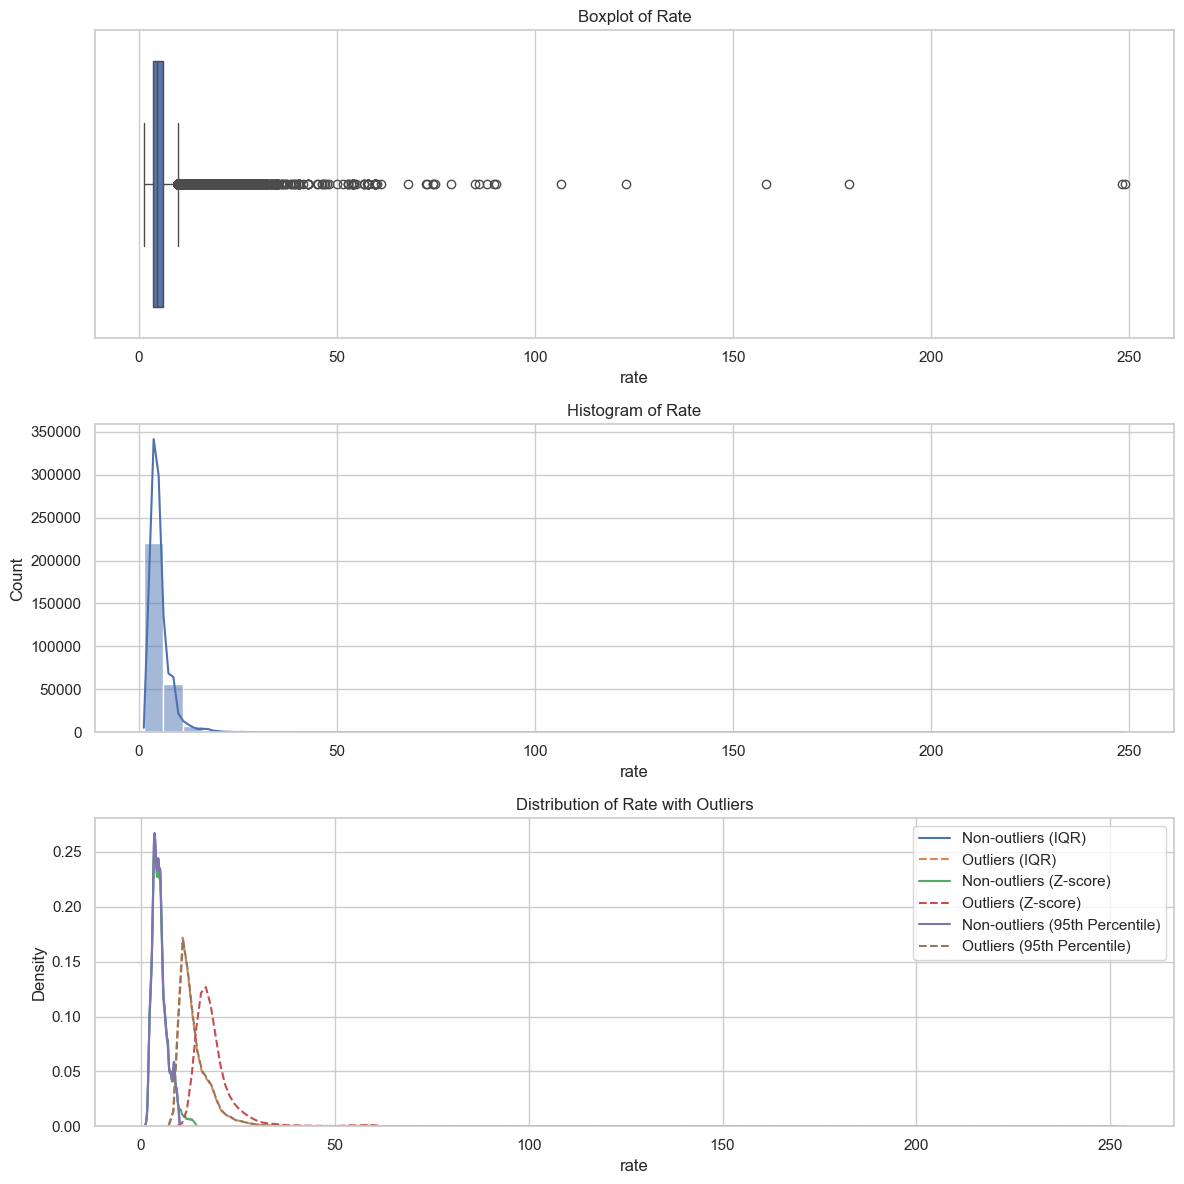

In [21]:
outliers_dict = detect_outliers(train_df, "rate")
plot_outliers(train_df, "rate", outliers_dict)

# valid_miles

## Добавить логарифм valid_miles


| Вариант | Плюсы | Минусы |
|------------------------------------------------|------------------------------------------------------------------------------------------|----------------------------------------------------------------|
| **Оставить `valid_miles` и `log_valid_miles`** | Модель может использовать обе информации.<br>Можно проверить важность обоих признаков. | Увеличение размерности данных.<br>Возможна избыточность. |
| **Оставить только `log_valid_miles`**| Убираем лишнюю корреляцию.<br>Простая интерпретация. | Если логарифм не улучшит модель, потеряем полезную информацию. |

- На первом этапе оставляем оба (valid_miles и log_valid_miles).
- После проверки важности признаков (feature importance) можно удалить valid_miles, если log_valid_miles окажется лучше.

In [58]:
for df_name in ["train_df", "validation_df", "test_df"]:
    df = locals()[df_name]
    df["log_valid_miles"] = np.log1p(df["valid_miles"])  # log1p безопаснее log

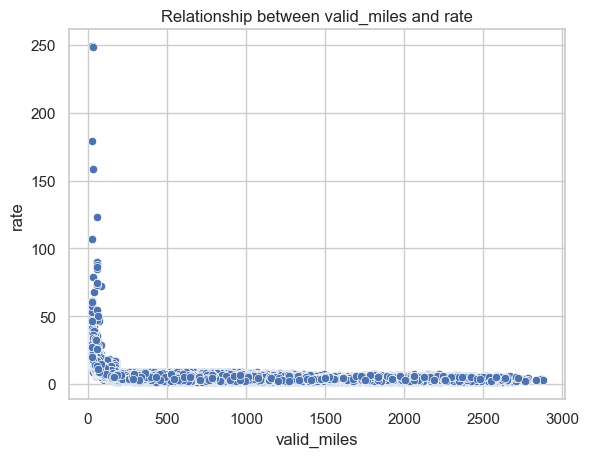

In [59]:
sns.scatterplot(x=train_df["valid_miles"], y=train_df["rate"])
plt.title("Relationship between valid_miles and rate")
plt.show()

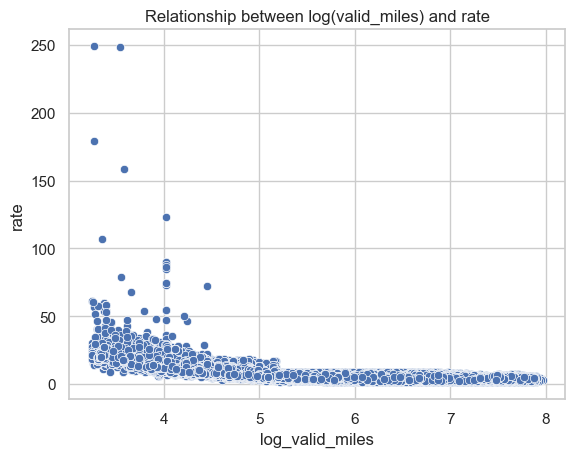

In [60]:
train_df["log_valid_miles"] = np.log1p(train_df["valid_miles"])  # log1p(0) = 0, безопаснее log
sns.scatterplot(x=train_df["log_valid_miles"], y=train_df["rate"])
plt.title("Relationship between log(valid_miles) and rate")
plt.show()

Что показывает график?
- При малых значениях log(valid_miles) (≈ 4–5) rate варьируется от 1 до 250, что говорит о высокой дисперсии.
- При увеличении log(valid_miles) (5+) rate стабилизируется и остается близким к нулю.
- Большинство значений log(valid_miles) лежат в диапазоне 4–7, что соответствует от 50 до 1000 миль.
- Логарифм valid_miles делает зависимость rate более плавной, что важно для линейных моделей.
- Высокая дисперсия при малых значениях valid_miles говорит о возможном влиянии других факторов (например, transport_type или origin_kma).
- Добавляем log(valid_miles) в модель.